In [46]:
#conda env create -f environment.yml
#conda activate sterzinger-igel-2023-data
#pip install pandas numpy matplotlib tqdm xarray pyrams pint-xarray

In [47]:
import xarray as xr
import pyrams.xarray
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from glob import glob
from tqdm import tqdm
import pint_xarray
ureg = pint_xarray.unit_registry

simlist = [
    'salt20',
    'salt200',
    'salt400',
    'salt600',
    'salt800',
    'salt1000',
]

# simlist = ['salt' + l for l in simlist]

sims = {}
for sim in simlist:
    data = xr.open_dataset(f'model_data/{sim}.nc')
    data = data.rams.apply_variable_metadata()
    data.time.attrs['units'] = 'hour'
    sims[sim] = data

cmap = plt.get_cmap('jet', len(sims))

In [48]:
plots_dir = './plots/'

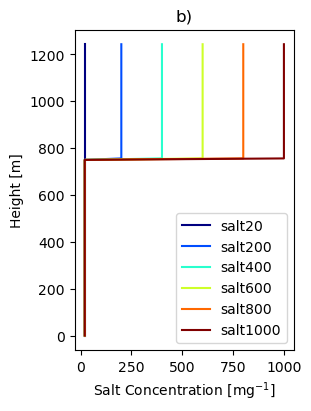

In [49]:
fig = plt.figure(figsize=(3,4), constrained_layout=True)
for i,(name, ds) in enumerate(sims.items()):
    ds.isel(time=0).SALT_FILM_NP.pint.to('1/mg').plot(y='z', label=name, color=cmap(i))
plt.legend()
plt.xlabel('Salt Concentration [mg$^{-1}$]')
plt.ylabel('Height [m]')
plt.title('b)')
plt.savefig(f'{plots_dir}/02b.png', dpi=500)

In [50]:
!convert +append plots/02a.png plots/02b.png plots/02.png

Invalid Parameter - plots


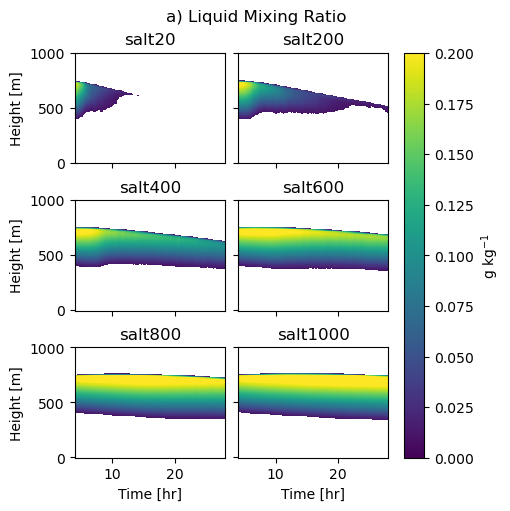

In [51]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(5,5))

for i,((name, ds), ax) in enumerate(zip(sims.items(), axs.flatten())):
    ds = ds.sel(time=slice(4,28))
    p = ds.RCP.where(ds.RCP >= 0.01 * ureg('g/kg')).pint.to('g/kg').plot(x='time', vmin=0, vmax=.2, ax=ax, add_colorbar=False)
    # c=(ds.RPP + ds.RSP + ds.RAP + ds.RGP + ds.RHP).pint.to('g/kg').plot.contour(x='time',ax=ax, colors='k')
    
    # ax.clabel(c, inline=True)
    
    ax.set_title(name)
    p.set_rasterized(True)
    if i%2 != 0: ax.set_ylabel('')
    else: ax.set_ylabel('Height [m]')
    if i not in [4,5]: ax.set_xlabel('')
    else: ax.set_xlabel('Time [hr]')
       
plt.ylim(None,1000)
plt.colorbar(p, ax=axs.ravel().tolist(), shrink=1, label='g kg$^{-1}$')
plt.suptitle('a) Liquid Mixing Ratio')
plt.savefig(f'{plots_dir}/03a.png', dpi=500)

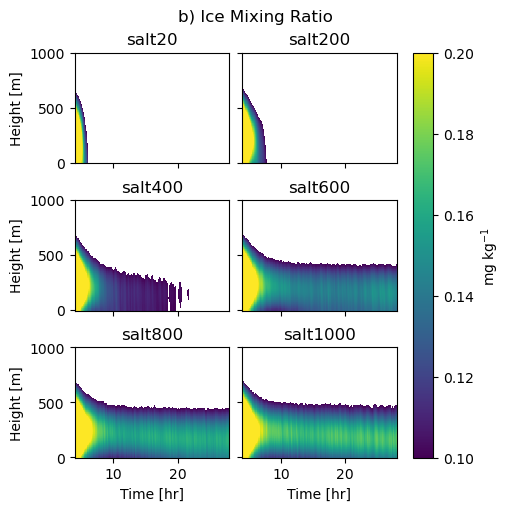

In [52]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(5,5))

for i,((name, ds), ax) in enumerate(zip(sims.items(), axs.flatten())):
    ds = ds.sel(time=slice(4,28))
    # p = ds.RCP.where(ds.RCP >= 0.01 * ureg('g/kg')).pint.to('g/kg').plot(x='time', vmin=0, vmax=.2, ax=ax, add_colorbar=False)
    ice=(ds.RPP + ds.RSP + ds.RAP + ds.RGP + ds.RHP).pint.to('mg/kg')

    c=ice.where(ice > 0.1*ureg('mg/kg')).plot(x='time',ax=ax, vmin=0.1, vmax=.2, add_colorbar=False)
    
    # ax.clabel(c, inline=True)
    
    ax.set_title(name)
    c.set_rasterized(True)
    
    if i%2 != 0: ax.set_ylabel('')
    else: ax.set_ylabel('Height [m]')
    if i not in [4,5]: ax.set_xlabel('')
    else: ax.set_xlabel('Time [hr]')
    
plt.ylim(None,1000)
plt.colorbar(c, ax=axs.ravel().tolist(), shrink=1, label='mg kg$^{-1}$')
# plt.legend()
# plt.xlabel('mg$^{-1}$')
# plt.title('Initial Salt Concentration Profiles')
plt.suptitle('b) Ice Mixing Ratio')
plt.savefig(f'{plots_dir}/03b.png', dpi=500)

In [53]:
!convert +append plots/03a.png plots/03b.png plots/03.png

Invalid Parameter - plots


Warning, RDP not found in dataset - skipping in LWC calculation
Warning, RDP not found in dataset - skipping in LWC calculation
Warning, RDP not found in dataset - skipping in LWC calculation
Warning, RDP not found in dataset - skipping in LWC calculation
Warning, RDP not found in dataset - skipping in LWC calculation
Warning, RDP not found in dataset - skipping in LWC calculation


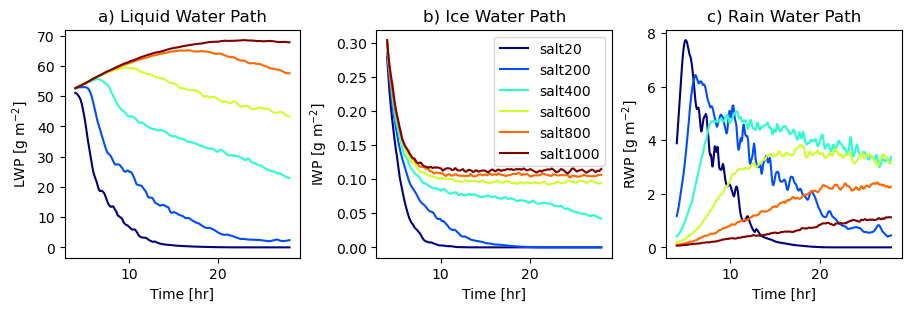

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,3), constrained_layout=True)
for i,(name, ds) in enumerate(sims.items()):
    ds = ds.sel(time=slice(4,28))
    (ds.rams.lwp * ureg('m')).pint.to('g/m^2').plot(ax=ax1,x='time', label=name, color=cmap(i))

ax1.set_ylabel('LWP [g m$^{-2}$]')
ax1.set_xlabel('Time [hr]')
ax1.set_title('a) Liquid Water Path')

for i,(name, ds) in enumerate(sims.items()):
    ds = ds.sel(time=slice(4,28))
    (ds.rams.iwp * ureg('m')).pint.to('g/m^2').plot(ax=ax2, x='time', label=name, color=cmap(i))

ax2.legend()
ax2.set_ylabel('IWP [g m$^{-2}$]')
ax2.set_xlabel('Time [hr]')
ax2.set_title('b) Ice Water Path')

for i,name in enumerate(sims.keys()):
    ds = sims[name]
    ((ds.RRP * ds.DN0).integrate('z') * ureg('m')).sel(time=slice(4,28)).pint.to('g/m^2').plot(ax=ax3, label=name, color=cmap(i))
#plt.legend(ncol=2,bbox_to_anchor=(.15, 0.7))
ax3.set_title('c) Rain Water Path')
ax3.set_xlabel('Time [hr]')
ax3.set_ylabel('RWP [g m$^{-2}$]')
#plt.savefig(f'{plots_dir}/07.png', dpi=500)

plt.savefig(f'{plots_dir}/04.png', dpi=500)

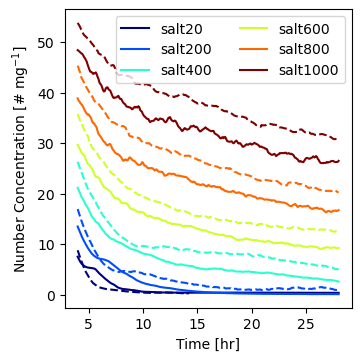

In [55]:
fig = plt.figure(figsize=(3.5,3.5), constrained_layout=True)
for i,name in enumerate(sims.keys()):
    ds = sims[name].sel(time=slice(4,28))
    bl_mass = (ds.SALT_FILM_NP + ds.REGEN_AERO1_NP).isel(z=0)
    acc = ds.ACCPAERO
    bl_mass.pint.to('1/mg').plot(color=cmap(i), label=name)
    ds.CCP.where(ds.RCP >= 0.01 *ureg('g/kg')).mean('z').pint.to('1/mg').plot(color=cmap(i), linestyle='--')
    # bl_mass.diff('time').plot(color=cmap(i), label=name) 
    # bl_rate = bl_mass.differentiate('time')
    # acc_rate = acc.differentiate('time')
    # acc_rate.plot(color=cmap(i), label=name)
    # (bl_rate + acc_rate).plot(color=cmap(i), label=name)
    
plt.legend(ncol=2)
plt.ylabel('Number Concentration [# mg$^{-1}$]')
plt.xlabel('Time [hr]')
#plt.title('Surface Salt/Mean Cloud Number Concentration')
plt.savefig(f'{plots_dir}/05.png', dpi=500)

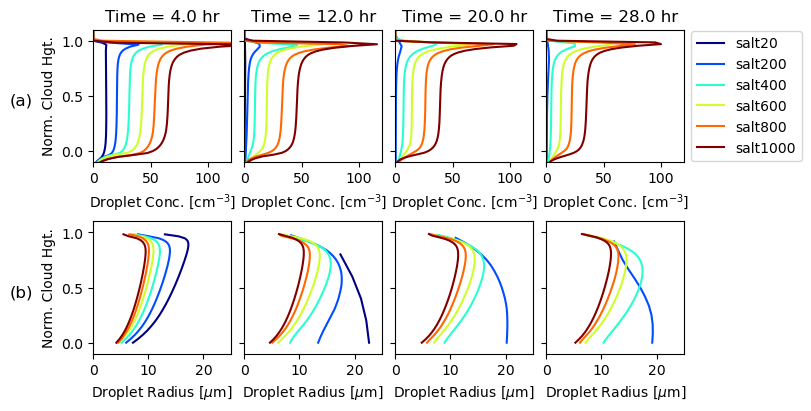

In [56]:
fig, axs = plt.subplots(2, 4, sharey=True, constrained_layout=True, figsize=(8,4))
axs = axs.flatten()

times = [4,12,20,28]

for j in range(4):
#for t,ax in zip(times, axs):
    handles = []
    for i,(name, ds) in enumerate(sims.items()):
        ds1 = ds.sel(time=times[j])
        ax=axs[j]
        p = (ds1.CCP * ds1.DN0).pint.to('1/cm^3').plot(y='Z_NORM_CLOUD', ax=axs[j], color=cmap(i), label=name)
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(0,120)
        handles = handles + p
        ax.set_xlabel('Droplet Conc. [cm$^{-3}$]')
        ax.set_title(f'Time = {times[j]}.0 hr')
    if times[j] in [4]: 
        ax.set_ylabel('Norm. Cloud Hgt.')
    else: ax.set_ylabel('')
    
fig.supylabel('(a)\n\n\n\n\n\n\n\n\n\n\n(b)\n',rotation='horizontal')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#for t,ax in zip(times, axs):
for j in range(4):
    for i,(name, ds) in enumerate(sims.items()):
        ds1 = ds.sel(time=times[j])
        ax=axs[j+4]
        v = ds1.rams.cloudradius
        l = v.where(ds1.RCP >= 0.01 * ureg('g/kg')).pint.to('micron').plot(y='Z_NORM_CLOUD', ax=axs[j+4], color=cmap(i), label=name)
        ax.set_ylim(-0.1,1.1)
        # handles.append(p[0].get_label())
        handles = handles + l
        ax.set_xlabel('Droplet Radius [$\mu$m]')
        ax.set_xlim(0,25)
    if times[j] in [4]: ax.set_ylabel('Norm. Cloud Hgt.')
    else: ax.set_ylabel('')

plt.savefig(f'{plots_dir}/06.png', dpi=500)


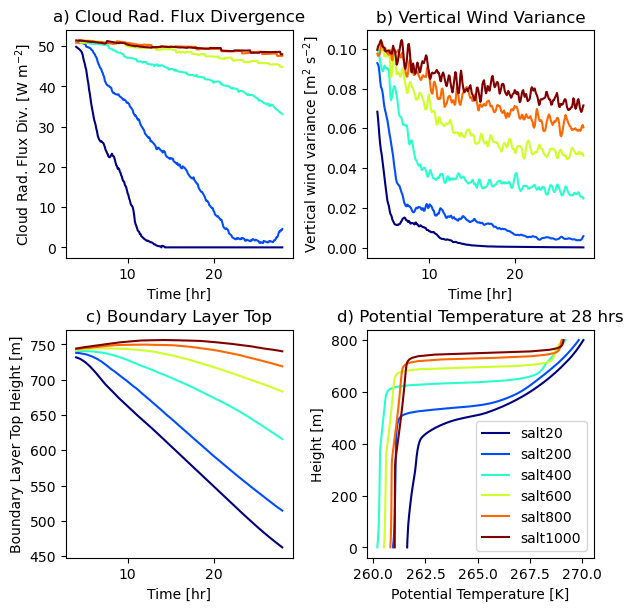

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(6,6), constrained_layout=True)
axs=axs.flatten()

cp = 1004 * ureg('J/kg/K')

for i, (name,ds) in enumerate(sims.items()):
    ds = ds.sel(time=slice(4,28))
    v = -1* (ds.FTHRD * cp * ds.DN0).where(ds.Z_NORM_CLOUD <= 1,0).where(ds.Z_NORM_CLOUD >= 0,0).integrate('z') * ureg('m')
    v.pint.to('W/m^2').plot(ax=axs[0], label=name, color=cmap(i))
axs[0].set_ylabel('Cloud Rad. Flux Div. [W m$^{-2}$]')
axs[0].set_xlabel('Time [hr]')
axs[0].set_title('a) Cloud Rad. Flux Divergence')

for i,name in enumerate(sims.keys()):
    ds = sims[name]
    (ds.VFLXW).sel(time=slice(4,28)).mean('z').plot(label=name, color=cmap(i),ax=axs[1])
axs[1].set_ylabel('Vertical wind variance [m$^2$ s$^{-2}$]')
axs[1].set_title('b) Vertical Wind Variance')
axs[1].set_xlabel('Time [hr]')

for i,(name, ds) in enumerate(sims.items()):
    ds = ds.sel(time=slice(4,28))
    ds.BLTOP.plot(x='time', label=name, color=cmap(i),ax=axs[2])

axs[2].set_ylabel('Boundary Layer Top Height [m]')
axs[2].set_title('c) Boundary Layer Top')
axs[2].set_xlabel('Time [hr]')

for i,(name, ds) in enumerate(sims.items()):
    ds = ds.sel(time=28, z=slice(0,800))
    ds.THETA.plot(y='z', label=name, color=cmap(i),ax=axs[3])
    
axs[3].set_xlabel('Potential Temperature [K]')
axs[3].set_ylabel('Height [m]')
axs[3].set_title('d) Potential Temperature at 28 hrs')
axs[3].legend()

plt.savefig(f'{plots_dir}/07.png', dpi=500)

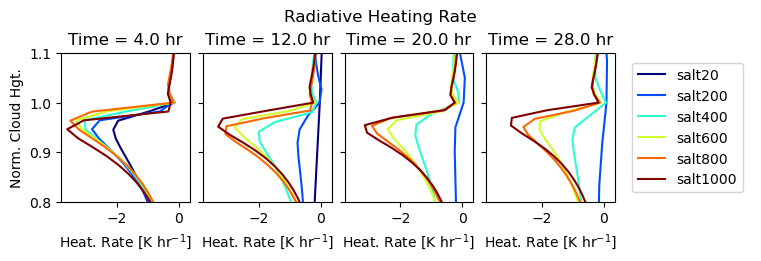

In [58]:
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, constrained_layout=True, figsize=(7.5,2.5))
axs = axs.flatten()

times = [4, 12, 20, 28]

for t,ax in zip(times, axs):
    handles = []
    for i,(name, ds) in enumerate(sims.items()):
        ds1 = ds.sel(time=t)
        l = (ds1.FTHRD).pint.to('K/hr').plot(y='Z_NORM_CLOUD', ax=ax, color=cmap(i), label=name)
        ax.set_ylim(.8,1.1)
        # handles.append(p[0].get_label())
        handles = handles + l
        ax.set_xlabel('Heat. Rate [K hr$^{-1}$]')
        ax.set_title(f'Time = {t}.0 hr')
    if t in [4]: ax.set_ylabel('Norm. Cloud Hgt.')
    else: ax.set_ylabel('')

fax = axs[-1]
labs = [l.get_label() for l in handles]
fax.legend(handles, labs, loc='center')
fax.set_axis_off()
plt.suptitle('Radiative Heating Rate')
plt.savefig(f'{plots_dir}/08.png', dpi=500)


Text(0.5, 0.98, 'Vertical wind variance')

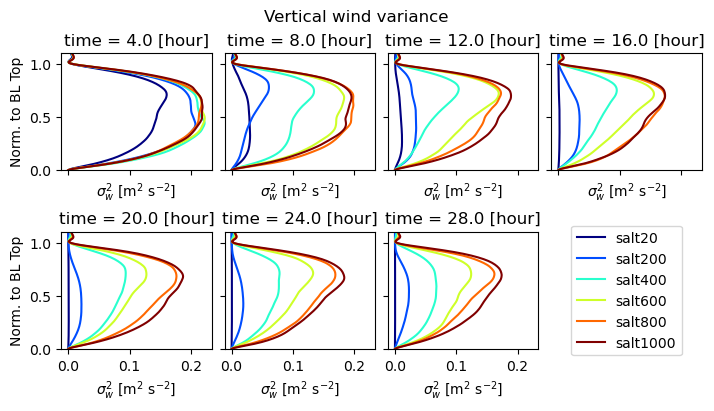

In [59]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, constrained_layout=True, figsize=(7,4))
axs = axs.flatten()

times = [4, 8, 12, 16, 20, 24, 28]

for t,ax in zip(times, axs):
    handles = []
    for i,(name, ds) in enumerate(sims.items()):
        ds1 = ds.sel(time=t)
        l = (ds1.VFLXW).plot(y='Z_NORM_BLTOP', ax=ax, color=cmap(i), label=name)
        ax.set_ylim(.0,1.1)
        # handles.append(p[0].get_label())
        handles = handles + l
        ax.set_xlabel('$\sigma_w^2$ [m$^2$ s$^{-2}$]')
    # ax.legend()
    if t in [4,20]: ax.set_ylabel('Norm. to BL Top')
    else: ax.set_ylabel('')

fax = axs[-1]
labs = [l.get_label() for l in handles]
fax.legend(handles, labs, loc='center')
fax.set_axis_off()
plt.suptitle('Vertical wind variance')
#plt.savefig(f'{plots_dir}/10b.png', dpi=500)


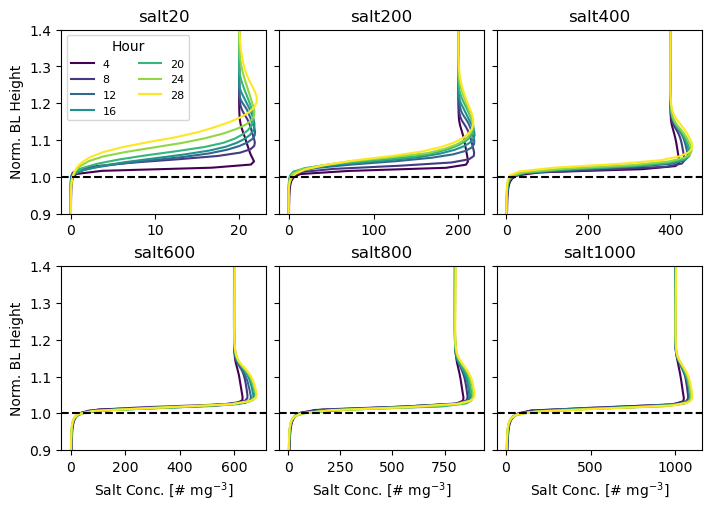

In [60]:
fig, axs = plt.subplots(2,3, sharey=True, constrained_layout=True, figsize=(7,5))

times = [4, 8, 12, 16, 20, 24, 28]
colors = plt.get_cmap('viridis', len(times))

for ((name,ds), ax) in zip(sims.items(), axs.flatten()):
    for i,t in enumerate(times):
        ds1 = ds.sel(time=t)
        aero = (ds1.REGEN_AERO1_NP + ds1.SALT_FILM_NP)
        ax.set_ylim(0.9, 1.4)
        aero.pint.to('1/mg').plot(y='Z_NORM_BLTOP', ax=ax, color=colors(i), label=t)
    
    ax.axhline(1, color='k', linestyle='--')
    ax.set_title(name)
    ax.set_ylabel('')   
    ax.set_xlabel('')

axs[1,0].set_xlabel('Salt Conc. [# mg$^{-3}$]')    
axs[1,1].set_xlabel('Salt Conc. [# mg$^{-3}$]') 
axs[1,2].set_xlabel('Salt Conc. [# mg$^{-3}$]') 
axs[0,0].set_ylabel('Norm. BL Height')
axs[1,0].set_ylabel('Norm. BL Height')
axs[0,0].legend(ncol=2, title='Hour', fontsize=8)
plt.savefig(f'{plots_dir}/09.png', dpi=500)